In [25]:
#packages
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from accelerate import Accelerator
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
import accelerate as a 
import os 
#self made 
#import research as r
from model import SPHNet
from dataproccesing import process 
import dataproccesing as dp
from training import Train

In [26]:
#reload dataproccesing module
import importlib
importlib.reload(dp)


<module 'dataproccesing' from '/home/grae/Coding projects/SPHnet-pricePrediction/dataproccesing.py'>

In [28]:

dataPARAMS = {
    "file_path": "data/btc15m.csv",
    "date_column": "timestamp",
    "target_column": "close",
    "window_size": 256,
    "batch_size": 128,
    "val_size": 0.2,
    "test_size": 0.1,
    }
trainLoader, valLoader, testLoader, scaler, feature_columns = dp.process(**dataPARAMS)

# infer number of features from the dataset (window samples shape = [N, seq_len, num_features])
num_features = trainLoader.dataset.X.shape[2]

modelPARAMS = {
    "num_features": num_features,
    "patch_size": 8,
    "embed_dim": 256,
    "vit_num_layers": 4,
    "transformer_num_layers": 4,
    "num_heads": 8,
    "ff_dim": 512,
    "dropout": 0.4,
    "output_dim": 1,
}
# make sure the class name matches what's defined in model.py
model = SPHNet(**modelPARAMS)

trainingPARAMS = {
    "valGAP": 1,
    "criterion": nn.MSELoss(),
    "epochs": 4,
    "model": model,
    "optimizer": torch.optim.Adam(model.parameters(), lr=1e-4),
    "trainLoader": trainLoader,
    "valLoader": valLoader,
    "testLoader": testLoader,
    "scheduler": StepLR(torch.optim.Adam(model.parameters(), lr=1e-4), step_size=10, gamma=0.1),
    "metrics": None,
}

# training the model

In [15]:
TrainedModel = Train(**trainingPARAMS)

Epoch 1 /4 | Train Loss: 0.0018: 100%|██████████| 556/556 [00:29<00:00, 19.11batch/s]


Epoch 1, Validation Loss: 0.000502


Epoch 2 /4 | Train Loss: 0.0012: 100%|██████████| 556/556 [00:29<00:00, 19.14batch/s]


Epoch 2, Validation Loss: 0.000418


Epoch 3 /4 | Train Loss: 0.0010: 100%|██████████| 556/556 [00:28<00:00, 19.27batch/s]


Epoch 3, Validation Loss: 0.000137


Epoch 4 /4 | Train Loss: 0.0009: 100%|██████████| 556/556 [00:28<00:00, 19.26batch/s]

Epoch 4, Validation Loss: 0.000488


Testing Loss: 0.0001647191140896604


In [16]:
torch.save(TrainedModel.state_dict(), 'models/sphnet_model_1re.pth')
print("Model saved successfully into 'models/sphnet_model_1re.pth'")

Model saved successfully into 'models/sphnet_model_1re.pth'


In [ ]:
torch.load(TrainedModel.state_dict(), 'models/sphnet_model_1re.pth')
print("Model loaded successfully from 'models/sphnet_model_1re.pth'")

# testing the model

based on the paper their are a few different tests that i can do

for price prediction:
    - r^2: a coefficient of dermination
    - MSE: avg squared distance of prediction
for direction prediction:
    - precision: TP / TP + FP
    - accuracy: (TP + FP) / (TP + FP + TN + FN)
    - recall: TP / TP + FN
TP, TN, FP, FN are defined as: (relative to A being up as a class)
    - TP: y == A and y-hat == A
    - TN: y != A and y-hat != A
    - FP: y == A but y-hat != A
    - FN: y != A but y-hat == A 

In [17]:
#price based tests as defined above

#testing the model


In [29]:
# Evaluate model on test set (price metrics)
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TrainedModel = TrainedModel.to(device)
TrainedModel.eval()

all_preds = []
all_targets = []
all_last_close = []
with torch.no_grad():
    for inputs, targets in testLoader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = TrainedModel(inputs)
        preds = outputs.detach().cpu().numpy().reshape(-1)
        targs = targets.detach().cpu().numpy().reshape(-1)
        last_close = inputs.detach().cpu().numpy()[:, -1, :]
        all_preds.append(preds)
        all_targets.append(targs)
        all_last_close.append(last_close)

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
all_last_close = np.concatenate(all_last_close)

# inverse transform using scaler and feature_columns
try:
    idx = feature_columns.index('close')
except Exception:
    idxs = [i for i,c in enumerate(feature_columns) if c.lower()=='close']
    idx = idxs[0] if idxs else 0

def inverse_target(vec):
    N = vec.shape[0]
    tmp = np.zeros((N, len(feature_columns)))
    tmp[:, idx] = vec
    inv = scaler.inverse_transform(tmp)
    return inv[:, idx]

preds_orig = inverse_target(all_preds)
targets_orig = inverse_target(all_targets)

mse = mean_squared_error(targets_orig, preds_orig)
r2 = r2_score(targets_orig, preds_orig)
print(f"Test MSE (orig scale): {mse:.6f}")
print(f"Test R2 (orig scale): {r2:.6f}")

Test MSE (orig scale): 1381457.265047
Test R2 (orig scale): 0.997253


In [30]:
# Direction metrics (compare predicted movement vs last observed close)
from sklearn.metrics import precision_score, accuracy_score, recall_score

# last_close is array of shape (N, num_features), take idx column
last_close_vals = all_last_close[:, idx]

true_dir = (targets_orig > last_close_vals).astype(int)
pred_dir = (preds_orig > last_close_vals).astype(int)

precision = precision_score(true_dir, pred_dir, zero_division=0)
accuracy = accuracy_score(true_dir, pred_dir)
recall = recall_score(true_dir, pred_dir, zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 1.0000
Accuracy: 1.0000
Recall: 1.0000


TrainingEpoch 1 /4:  48%|████▊     | 269/556 [39:42<42:21,  8.86s/batch]



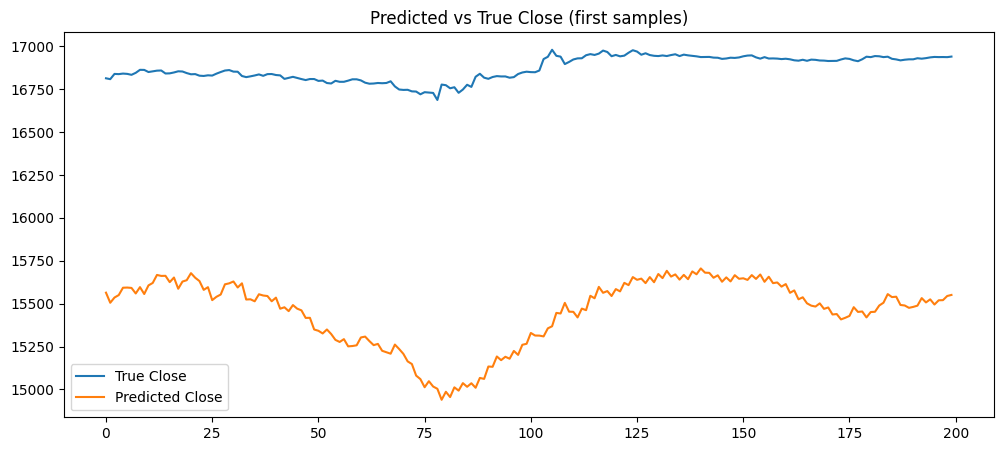

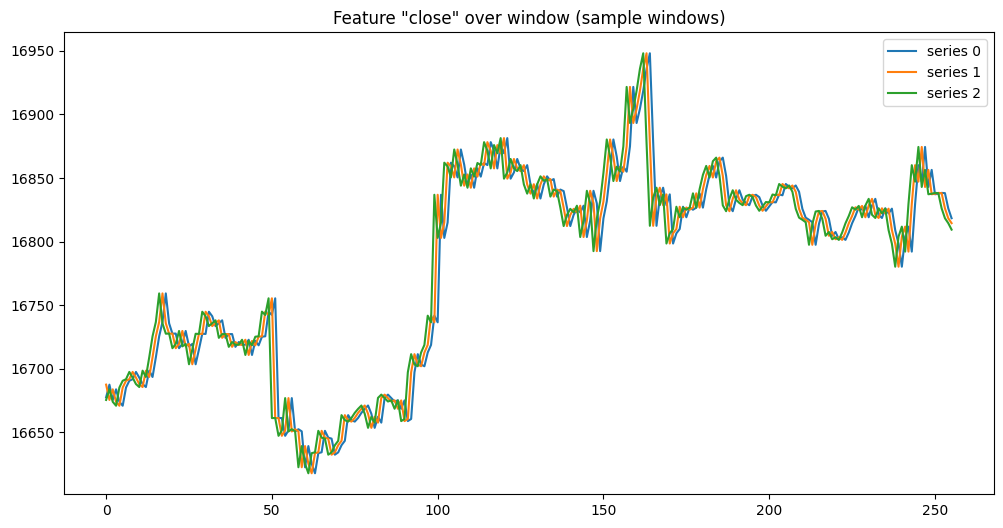

In [31]:
# Plots: predicted vs true close and a few features
import matplotlib.pyplot as plt

# plot first 200 samples
n = min(200, len(preds_orig))
plt.figure(figsize=(12,5))
plt.plot(targets_orig[:n], label='True Close')
plt.plot(preds_orig[:n], label='Predicted Close')
plt.legend()
plt.title('Predicted vs True Close (first samples)')
plt.show()

# plot selected feature series from test set (first window of first batch)
inputs_batch, targets_batch = next(iter(testLoader))
inputs_np = inputs_batch.numpy()
Nplot = min(3, inputs_np.shape[0])
feature_idx = idx
plt.figure(figsize=(12,6))
for i in range(Nplot):
    series = inputs_np[i,:,feature_idx]
    tmp = np.zeros((series.shape[0], len(feature_columns)))
    tmp[:, feature_idx] = series
    series_orig = scaler.inverse_transform(tmp)[:, feature_idx]
    plt.plot(series_orig, label=f'series {i}')
plt.title('Feature "close" over window (sample windows)')
plt.legend()
plt.show()

# model conclusions

i can infer that the direction accuracy is WAY to good to be real without any lookahead or some unrealistic bias : 100% on all metrics

i now **need** to find out what that lookahead is and retrain